In [1]:
from mumax_helper import * 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks
from scipy.fft import rfft
from adaptive import Runner, Learner1D

In [59]:
# NUMERICAL PARAMETERS RELEVANT FOR THE SPECTRUM ANALYSIS
fmax = 1e9        # maximum frequency (in Hz) of the sinc pulse
T    = 5e-9        # simulation time (longer -> better frequency resolution)
dt = .1e-10  # the sample time (Nyquist theorem taken into account)


# Note that this is a format string, this means that the statements inside the
# curly brackets get evaluated by python. In this way, we insert the values of
# the variables above in the script.

def resonance_script():

    script = f"""
    nx   := 128
    setgridsize(200,200,1)
    setcellsize(1e-9,1e-9,1e-9)

    domain := circle(200e-9)
    setgeom(domain)

    Msat = 1e6
    Aex = 10e-12
    Dind = 2.2e-3
    Ku1 = 1e6
    AnisU = vector(0,0,1)
    alpha = 0.001

    B_ext = vector(0, 0, .01 * sinc( 2*pi*{fmax}*t)) 
    // B_ext = vector(0, 0, 1.10 * sin( 2*pi*{fmax}*t)) 

    dia := 30e-9
    sep := 50e-9
    shape_1 := circle(dia).transl(sep, 0, 0)
    shape_2 := circle(dia).transl(-sep, 0, 0)

    m = Uniform(0, 0, 1)
    m.setInShape(shape_1, NeelSkyrmion(1, -1).transl(sep, 0, 0 ))
    m.setInShape(shape_2, NeelSkyrmion(1, -1).transl(-sep, 0, 0 ))

    minimize()
    save(m)
    tableautosave({dt})
    run({T})
    """


    return script

run_mumax3(resonance_script(),"Breathing mode excite"); 


<AxesSubplot:xlabel='t'>

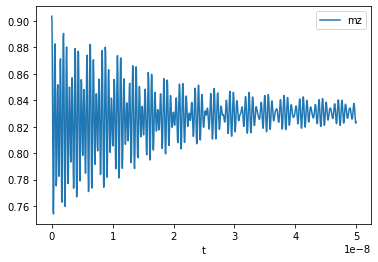

In [5]:
table.plot(x='t',y='mz')

In [20]:
arr = np.load(r"Breathing mode excite high power.out\m.npz")
m = np.array([arr[key] for key in arr.keys()]); m 




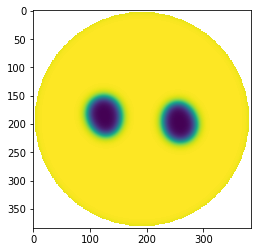

In [23]:
mz_array = m[, 2, 0, :, :]
plt.imshow(mz_array)

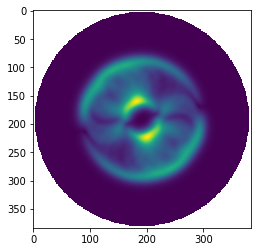

In [43]:
plt.imshow(np.abs(mz_fft[peak_locations][1]))

Peak frequencies: [1.58316633e+09 2.02404810e+09]


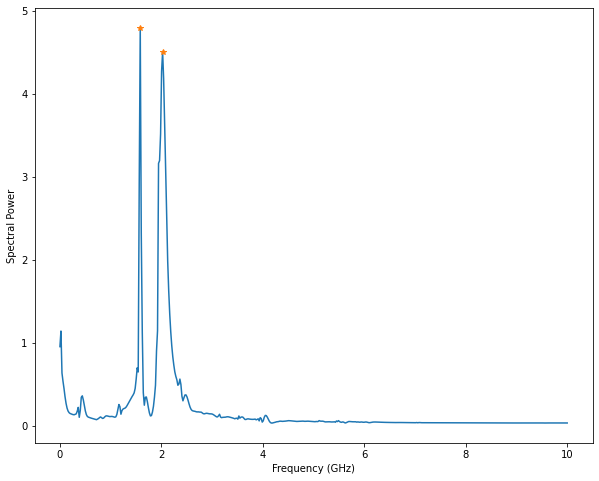

In [11]:
fmax=10e9
table = read_mumax3_table(r"Breathing mode excite high power.out\table.txt")


dm = table["mz"] - np.median(table["mz"])

spectr = np.abs(np.fft.fft(dm))

real_spectr = spectr[:int(np.ceil(len(spectr)/2))]
freq = np.linspace(0, fmax, len(real_spectr))

plt.figure(figsize=(10, 8))

plt.plot(freq/1e9, real_spectr)
peak_locations = find_peaks(real_spectr, prominence=3)[0]
peak_freqs = freq[peak_locations]
print("Peak frequencies:", peak_freqs)
peak_spectra = spectr[peak_locations]
plt.plot(peak_freqs/1e9, peak_spectra, '*')
# plt.xlim(0, 1)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Spectral Power')
plt.yscale('linear')

In [25]:
peak_locations

array([ 79, 101], dtype=int64)

1
2


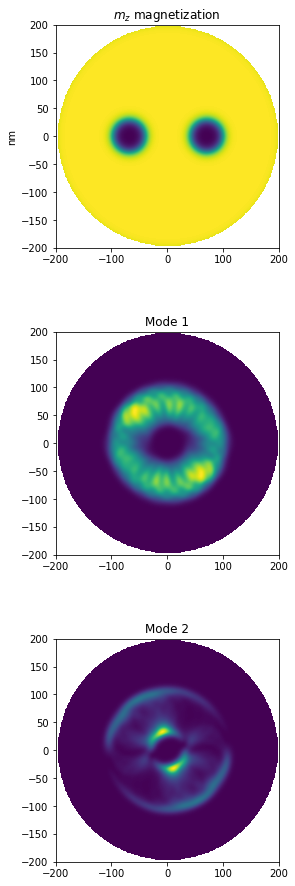

In [44]:
# Stack all snapshots (4D arrays) of the magnetization on top of each other
# The results in a single 5D array (first index is the snapshot index)





# Select the z component and the (only) layer z=0
mz = m[:, 2, 0, :, :]

# Apply the FFT for every cell
mz_fft = np.fft.fft(mz, axis=0)


# Plot the result
num_images = len(peak_locations) + 1 

plt.figure(figsize=(4, 16))
plt.subplot(num_images, 1, 1)
plt.title("$m_z$ magnetization")
plt.imshow(mz[0], extent=[-200, 200, -200, 200])
# plt.xlabel('nm')
plt.ylabel('nm')

# 

for peak in enumerate(peak_locations):
    peak_count = peak[0] + 1
    print(peak_count)
    peak_idx = peak[1]
    mode = mz_fft[peak_idx]
    plt.subplot(num_images, 1, peak_count+1)
    plt.imshow(np.abs(mode)**2, extent=[-200, 200, -200, 200])
    plt.title(f"Mode {peak_count}")


plt.show()
# plt.clear()

In [66]:
# NUMERICAL PARAMETERS RELEVANT FOR THE SPECTRUM ANALYSIS
fmax = 10e9        # maximum frequency (in Hz) of the sinc pulse
T    = 50e-9        # simulation time (longer -> better frequency resolution)
dt = 1/(2*fmax)  # the sample time (Nyquist theorem taken into account)


# Note that this is a format string, this means that the statements inside the
# curly brackets get evaluated by python. In this way, we insert the values of
# the variables above in the script.

def simulation(freq,amp):

    dt = 1/(2*freq)

    script = f"""
    n   := 384
    length := 200e-9

    setgridsize(n,n,1)
    setcellsize(length/n,length/n,1e-9)

    domain := circle(length*.99)
    setgeom(domain)

    Msat = 1e6
    Aex = 10e-12
    Dind = 2.2e-3
    Ku1 = 1e6
    AnisU = vector(0, 0, 1)
    alpha = 0.001

    B_ext = vector(0, 0, {amp} * sinc( 2*pi*{freq}*t)) 
    TableAdd(B_ext)

    dia := 20e-9
    sep := 50e-9
    shape_1 := circle(dia).transl(sep, 0, 0)
    shape_2 := circle(dia).transl(-sep, 0, 0)

    m = Uniform(0, 0, 1)
    m.setInShape(shape_1, NeelSkyrmion(1, -1).transl(sep, 0, 0 ))
    m.setInShape(shape_2, NeelSkyrmion(1, -1).transl(-sep, 0, 0 ))


    // Save the topological charge density of a skyrmion
    //saveas(chargeDensity, "chargeDensity.ovf")

    minimize()
    autosave(m,{dt})
    tableautosave({dt})
    run({T})
    """

    return script

run_mumax3(simulation(10e9,.01),"Breathing mode excite high power")


([array([[[[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]]],
  
  
         [[[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]]],
  
  
         [[[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32),
  array([[[[nan, nan, nan, ..., nan, nan, nan],
     

In [9]:

def sim_func(freq):
    title = f"Twin Skyrmions f={freq}"
    m,table = run_mumax3(simulation(freq, .002), title)
    return calculate_velocity(m,table,scale=200e-9/384)

learner = Learner1D(sim_func, bounds=(.6e9, 4e9))

def goal(learner):
    return learner.loss() < 0.1  # continue until loss is small enough

runner = Runner(learner, goal, ntasks=1)  # start calculation on all CPU cores
# runner.live_info()  # shows a widget with status information
# runner.live_plot()
runner.task.print_stack()


Stack for <Task pending name='Task-5' coro=<AsyncRunner._run() running at c:\Users\foile\miniconda3\lib\site-packages\adaptive\runner.py:636>> (most recent call last):


  File "c:\Users\foile\miniconda3\lib\site-packages\adaptive\runner.py", line 636, in _run
    async def _run(self):


In [30]:
runner.task.print_stack()

No stack for <Task cancelled name='Task-5' coro=<AsyncRunner._run() done, defined at c:\Users\foile\miniconda3\lib\site-packages\adaptive\runner.py:636>>


In [4]:
freq_list = np.linspace(.5e9,4e9)

for freq in freq_list:
    title = f"Twin Skyrmions f={freq}"
    run_mumax3(simulation(freq,.002), title)

//mumax 3.10 [windows_amd64 go1.11.6(gc) CUDA-11.0]
//GPU info: NVIDIA GeForce RTX 3090(24575MB), CUDA Driver 11.6, cc=8.6, using cc=80 PTX
//(c) Arne Vansteenkiste, Dynamat LAB, Ghent University, Belgium
//This is free software without any warranty. See license.txt
//********************************************************************//
//  If you use mumax in any work or publication,                      //
//  we kindly ask you to cite the references in references.bib        //
//********************************************************************//
//output directory: Twin Skyrmions f=500000000.0.out/
//starting GUI at http://127.0.0.1:35367
n := 384
length := 200e-9
setgridsize(n, n, 1)
setcellsize(length/n, length/n, 1e-9)
domain := circle(length * .99)
setgeom(domain)
// Initializing geometry 0 %
// Initializing geometry 100 %
Msat = 1e6
Aex = 10e-12
Dind = 2.2e-3
Ku1 = 1e6
AnisU = vector(0, 0, 1)
alpha = 0.001
B_ext = vector(0, 0, 0.002*sin(2*pi*500000000.0*t))
TableAdd(B_ext)


KeyboardInterrupt: 

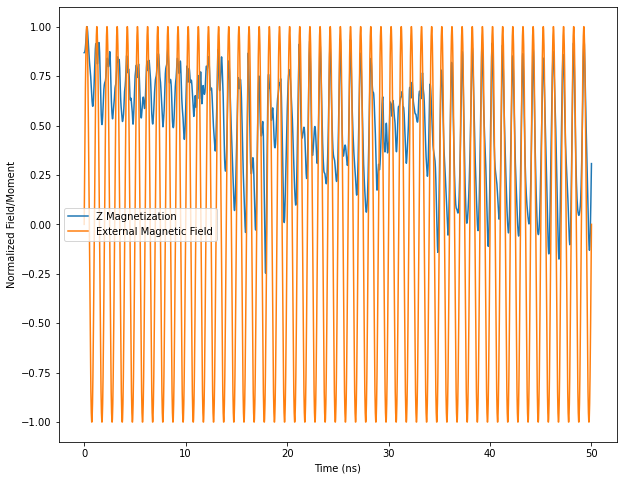

In [17]:
fmax = 5e9

table = read_mumax3_table(r"C:\Users\foile\OneDrive - University of Illinois - Urbana\Research\Calculations\Breathing mode drive.out\table.txt")

t = table['t'].values 
mz = table["mz"].values / np.max(table['mz'].values)
Bext = table["B_extz"].values / np.max(table['B_extz'].values)


plt.figure(figsize=(10, 8))

plt.plot(t*1e9, mz,label='Z Magnetization')
plt.plot(t*1e9, Bext,label='External Magnetic Field')
plt.xlabel('Time (ns)')
plt.ylabel('Normalized Field/Moment')
plt.legend()
plt.savefig('Drive.png',facecolor='white')
plt.show()


In [1]:
for x in range(len(m)):
    m0 = m[x]

    m0x = m0[0]
    m0y = m0[1]
    m0z = m0[2]

    dm0x_dx = np.diff(m0x,axis=1)[:,:,:-1]
    dm0y_dx = np.diff(m0y,axis=1)[:,:,:-1]
    dm0z_dx = np.diff(m0z,axis=1)[:,:,:-1]

    dm0x_dy = np.diff(m0x,axis=2)[:,:-1,:]
    dm0y_dy = np.diff(m0y,axis=2)[:,:-1,:]
    dm0z_dy = np.diff(m0z,axis=2)[:,:-1,:]

    dm0_dx = np.array([dm0x_dx,dm0y_dx,dm0z_dx])
    dm0_dy = np.array([dm0x_dy,dm0y_dy,dm0z_dy])
    cross_product = np.cross(dm0_dx,dm0_dy,axis=0)

    q_x = m0[0,:,:-1,:-1] * cross_product[0]
    q_y = m0[1,:,:-1,:-1] * cross_product[1]
    q_z = m0[2,:,:-1,:-1] * cross_product[2]
    q = q_x + q_y + q_z
    plt.imshow(q[0])
    plt.xlabel('nm')
    plt.ylabel('nm')
    label = r"Breathing mode drive.out/" + "q5" + str(x) + ".png"
    plt.savefig(label,facecolor='white')


NameError: name 'm' is not defined

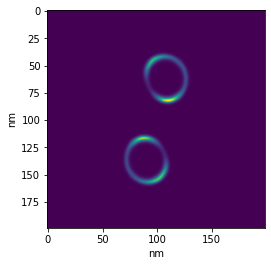

In [ ]:
for x in range(len(m)):
    m0 = m[x]

    m0x = m0[0]
    m0y = m0[1]
    m0z = m0[2]

    dm0x_dx = np.diff(m0x,axis=1)[:,:,:-1]
    dm0y_dx = np.diff(m0y,axis=1)[:,:,:-1]
    dm0z_dx = np.diff(m0z,axis=1)[:,:,:-1]

    dm0x_dy = np.diff(m0x,axis=2)[:,:-1,:]
    dm0y_dy = np.diff(m0y,axis=2)[:,:-1,:]
    dm0z_dy = np.diff(m0z,axis=2)[:,:-1,:]

    dm0_dx = np.array([dm0x_dx,dm0y_dx,dm0z_dx])
    dm0_dy = np.array([dm0x_dy,dm0y_dy,dm0z_dy])
    cross_product = np.cross(dm0_dx,dm0_dy,axis=0)

    q_x = m0[0,:,:-1,:-1] * cross_product[0]
    q_y = m0[1,:,:-1,:-1] * cross_product[1]
    q_z = m0[2,:,:-1,:-1] * cross_product[2]
    q = q_x + q_y + q_z
    plt.imshow(q[0])
    plt.xlabel('nm')
    plt.ylabel('nm')
    label = r"Breathing mode drive.out/" + "qCubed" + str(x) + ".png"
    plt.savefig(label,facecolor='white')
